In [1]:
# Data manipulation
import pandas as pd
import numpy as np
# Evaluation of the model
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.size'] = 18
%matplotlib inline
MAX_EVALS = 20
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer
import json
import shlex
import subprocess
import logging
from pprint import pprint
import re
import os

In [2]:
file_suffix = "BT-IO-400-400-400-16-" + str(MAX_EVALS)
project_dir = "/home/dsinghvi/project/progress/"
def runthebenchmark(hyperparameters):
    os.chdir(project_dir+'active/../')
    storeinfile(hyperparameters)
    out=subprocess.Popen(["python3","bt_read_config_general.py","-n16","-p4","-c400 400 400"], shell=False, stdout=subprocess.PIPE)
    logging.basicConfig(level=logging.DEBUG)
    output=out.stdout.read().decode('utf-8')
    print("output"+output)
    if len(output.split(" ")) > 5:
        values = output.split(" ")
        value = float(float(values[6])*1024)/float(values[5]) + float(float(values[3])*1024)/float(values[2])
        value = float(value)
        print(value)
        return float((value/1000)**3),output
    return 0,0;

In [3]:
def storeinfile(hyperparameters):
    data={"mpi": {"romio_ds_read": "enable", "romio_ds_write": "disable"}, "lfs": {"setstripe": {"size": "16777216", "count": 4}}}
    data["lfs"]["setstripe"]["size"] = int(hyperparameters["setstripe-size"])
    data["lfs"]["setstripe"]["count"] = int(hyperparameters["setstripe-count"])

    data["mpi"]["romio_ds_read"] = hyperparameters["romio_ds_read"]
    data["mpi"]["romio_ds_write"] = hyperparameters["romio_ds_write"]
    data["mpi"]["romio_cb_read"] = hyperparameters["romio_cb_read"]
    data["mpi"]["romio_cb_write"] = hyperparameters["romio_cb_write"]
    data["mpi"]["cb_buffer_size"] = str(int(hyperparameters["cb_buffer_size"]))
    with open("confex.json","w") as fp:
        json.dump(data,fp)
    print(data)


In [4]:
def objective(hyperparameters):
    global ITERATION
    ITERATION += 1
    start = timer()
    result=0
    while(result == 0):
        print("rerun")
        result,output = runthebenchmark(hyperparameters)
        print(result)
    run_time = timer() - start
    print({'loss': result, 'hyperparameters': hyperparameters, 'iteration': ITERATION, 'iteration_time': run_time, 'status': STATUS_OK})
    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([float(result), hyperparameters, ITERATION, run_time, output])
    return {'loss': float(result), 'hyperparameters': hyperparameters, 'iteration': ITERATION, 'iteration_time': run_time, 'status': STATUS_OK}


In [5]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

space = {
    'romio_ds_read' : hp.choice('romio_ds_read',['enable','disable']),
    'romio_ds_write' : hp.choice('romio_ds_write',['enable','disable']),
    'romio_cb_read' : hp.choice('romio_cb_read',['enable','disable']),
    'romio_cb_write' : hp.choice('romio_cb_write',['enable','disable']),
    'cb_buffer_size' : 1048576*hp.quniform('cb_buffer_size',1,256,1),
    'setstripe-size' : 65536*(hp.quniform('setstripe-size',0,156,1)),
    'setstripe-count' : hp.quniform('setstripe-count',0,30,1)
    
}

In [6]:
x = sample(space)
params = x
print(x)

cb_buffer_size_dist = []
for _ in range(1000):
    cb_buffer_size_dist.append(sample(space)['cb_buffer_size'])
    
setstripe_size_dist = []
for _ in range(1000):
    setstripe_size_dist.append(sample(space)['setstripe-size'])
    
setstripe_count_dist = []
for _ in range(1000):
    setstripe_count_dist.append(sample(space)['setstripe-count']) 
    
romio_ds_read_dist = []
for _ in range(20):
    romio_ds_read_dist.append(sample(space)['romio_ds_read'])
    
romio_ds_write_dist = []
for _ in range(20):
    romio_ds_write_dist.append(sample(space)['romio_ds_write'])
    
romio_cb_read_dist = []
for _ in range(20):
    romio_cb_read_dist.append(sample(space)['romio_cb_read']) 
    
romio_cb_write_dist = []
for _ in range(20):
    romio_cb_write_dist.append(sample(space)['romio_cb_write']) 
    

{'cb_buffer_size': 126877696.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 7.0, 'setstripe-size': 8192000.0}


In [7]:
# File to save first results
print(os.getcwd())
out_file = project_dir+'active/result/gbm_trials-'+file_suffix+'.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)
writer.writerow(['loss', 'params', 'iteration', 'train_time', 'output'])
of_connection.close()

/home/dsinghvi/project/progress/active


In [8]:
from hyperopt import tpe

# Create the algorithm
tpe_algorithm = tpe.suggest


from hyperopt import Trials

# Record results
bayes_trials = Trials()

from hyperopt import fmin


ITERATION = 20

best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = bayes_trials, max_evals = MAX_EVALS)

rerun                                               
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '183500800'}, 'lfs': {'setstripe': {'size': 8978432, 'count': 13}}}
outputbtio-pnetcdf-1.1.1 400-400-40016 1068.79 2441.41 2.28 797.37 2441.41 3.06 8978432 13 enable enable enable enable 183500800 

5474.409473024603                                   
164.06344835705406                                  
{'loss': 164.06344835705406, 'hyperparameters': {'cb_buffer_size': 183500800.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 13.0, 'setstripe-size': 8978432.0}, 'iteration': 21, 'iteration_time': 15.846866965293884, 'status': 'ok'}
  5%|▌         | 1/20 [00:15<05:01, 15.89s/it, best loss: 164.06344835705406]

INFO:hyperopt.tpe:tpe_transform took 0.011443 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 164.063448


rerun                                                                        
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '161480704'}, 'lfs': {'setstripe': {'size': 3997696, 'count': 12}}}
outputbtio-pnetcdf-1.1.1 400-400-40016 1382.00 2441.41 1.77 822.42 2441.41 2.97 3997696 12 disable enable enable enable 161480704 

4848.789294504859                                                            
113.99870986570039                                                           
{'loss': 113.99870986570039, 'hyperparameters': {'cb_buffer_size': 161480704.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 12.0, 'setstripe-size': 3997696.0}, 'iteration': 22, 'iteration_time': 14.4829994533211, 'status': 'ok'}
 10%|█         | 2/20 [00:30<04:38, 15.48s/it, best loss: 113.99870986570039]

INFO:hyperopt.tpe:tpe_transform took 0.009408 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 113.998710


rerun                                                                        
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '119537664'}, 'lfs': {'setstripe': {'size': 4194304, 'count': 10}}}
outputbtio-pnetcdf-1.1.1 400-400-40016 1256.56 2441.41 1.94 684.36 2441.41 3.57 4194304 10 enable enable enable enable 119537664 

5642.615565823144                                                            
179.65586007856024                                                           
{'loss': 179.65586007856024, 'hyperparameters': {'cb_buffer_size': 119537664.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 10.0, 'setstripe-size': 4194304.0}, 'iteration': 23, 'iteration_time': 17.20788742043078, 'status': 'ok'}
 15%|█▌        | 3/20 [00:47<04:32, 16.01s/it, best loss: 113.99870986570039]

INFO:hyperopt.tpe:tpe_transform took 0.009499 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 113.998710


rerun                                                                        
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '168820736'}, 'lfs': {'setstripe': {'size': 9306112, 'count': 4}}}
outputbtio-pnetcdf-1.1.1 400-400-40016 108.54 2441.41 22.49 907.51 2441.41 2.69 9306112 4 disable enable disable enable 168820736 

25787.813422828825                                                           
17149.187873385607                                                           
{'loss': 17149.187873385607, 'hyperparameters': {'cb_buffer_size': 168820736.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 4.0, 'setstripe-size': 9306112.0}, 'iteration': 24, 'iteration_time': 34.959342857822776, 'status': 'ok'}
 20%|██        | 4/20 [01:22<05:47, 21.70s/it, best loss: 113.99870986570039]

INFO:hyperopt.tpe:tpe_transform took 0.015624 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 113.998710


rerun                                                                        
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '139460608'}, 'lfs': {'setstripe': {'size': 8126464, 'count': 16}}}
outputbtio-pnetcdf-1.1.1 400-400-40016 126.68 2441.41 19.27 57.24 2441.41 42.65 8126464 16 enable disable disable disable 139460608 

63410.61338307762                                                            
254968.10881631586                                                           
{'loss': 254968.10881631586, 'hyperparameters': {'cb_buffer_size': 139460608.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 16.0, 'setstripe-size': 8126464.0}, 'iteration': 25, 'iteration_time': 71.71984549984336, 'status': 'ok'}
 25%|██▌       | 5/20 [02:34<09:10, 36.72s/it, best loss: 113.99870986570039]

INFO:hyperopt.tpe:tpe_transform took 0.009396 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 113.998710


rerun                                                                        
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '255852544'}, 'lfs': {'setstripe': {'size': 3211264, 'count': 7}}}
outputbtio-pnetcdf-1.1.1 400-400-40016 114.64 2441.41 21.30 1030.36 2441.41 2.37 3211264 7 disable disable disable enable 255852544 

24233.770718203978                                                           
14231.903286239356                                                           
{'loss': 14231.903286239356, 'hyperparameters': {'cb_buffer_size': 255852544.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 7.0, 'setstripe-size': 3211264.0}, 'iteration': 26, 'iteration_time': 33.380635297857225, 'status': 'ok'}
 30%|███       | 6/20 [03:07<08:20, 35.73s/it, best loss: 113.99870986570039]

INFO:hyperopt.tpe:tpe_transform took 0.009534 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 113.998710


rerun                                                                        
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '212860928'}, 'lfs': {'setstripe': {'size': 9502720, 'count': 18}}}
outputbtio-pnetcdf-1.1.1 400-400-40016 1184.18 2441.41 2.06 59.12 2441.41 41.30 9502720 18 disable disable enable disable 212860928 

44398.107881918535                                                           
87517.19433916075                                                            
{'loss': 87517.19433916075, 'hyperparameters': {'cb_buffer_size': 212860928.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 18.0, 'setstripe-size': 9502720.0}, 'iteration': 27, 'iteration_time': 53.11360137630254, 'status': 'ok'}
 35%|███▌      | 7/20 [04:00<08:52, 40.95s/it, best loss: 113.99870986570039]

INFO:hyperopt.tpe:tpe_transform took 0.014197 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 113.998710


rerun                                                                        
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '135266304'}, 'lfs': {'setstripe': {'size': 3342336, 'count': 29}}}
outputbtio-pnetcdf-1.1.1 400-400-40016 1174.14 2441.41 2.08 668.42 2441.41 3.65 3342336 29 disable enable enable enable 135266304 

5869.390366525776                                                            
202.19899130560833                                                           
{'loss': 202.19899130560833, 'hyperparameters': {'cb_buffer_size': 135266304.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 29.0, 'setstripe-size': 3342336.0}, 'iteration': 28, 'iteration_time': 15.525519760325551, 'status': 'ok'}
 40%|████      | 8/20 [04:16<06:40, 33.33s/it, best loss: 113.99870986570039]

INFO:hyperopt.tpe:tpe_transform took 0.009644 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 113.998710


rerun                                                                        
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '52428800'}, 'lfs': {'setstripe': {'size': 9437184, 'count': 8}}}
outputbtio-pnetcdf-1.1.1 400-400-40016 96.80 2441.41 25.22 580.59 2441.41 4.21 9437184 8 disable enable disable enable 52428800 

30132.457186569547                                                           
27359.21576925135                                                            
{'loss': 27359.21576925135, 'hyperparameters': {'cb_buffer_size': 52428800.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 8.0, 'setstripe-size': 9437184.0}, 'iteration': 29, 'iteration_time': 39.13504946231842, 'status': 'ok'}
 45%|████▌     | 9/20 [04:55<06:25, 35.08s/it, best loss: 113.99870986570039]

INFO:hyperopt.tpe:tpe_transform took 0.009441 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 113.998710


rerun                                                                        
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '85983232'}, 'lfs': {'setstripe': {'size': 3735552, 'count': 23}}}
outputbtio-pnetcdf-1.1.1 400-400-40016 658.80 2441.41 3.71 1308.95 2441.41 1.87 3735552 23 enable disable enable enable 85983232 

5704.714952100007                                                            
185.65294663222832                                                           
{'loss': 185.65294663222832, 'hyperparameters': {'cb_buffer_size': 85983232.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 23.0, 'setstripe-size': 3735552.0}, 'iteration': 30, 'iteration_time': 15.378263312391937, 'status': 'ok'}
 50%|█████     | 10/20 [05:11<04:51, 29.18s/it, best loss: 113.99870986570039]

INFO:hyperopt.tpe:tpe_transform took 0.009374 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 113.998710


rerun                                                                         
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '268435456'}, 'lfs': {'setstripe': {'size': 1376256, 'count': 23}}}
outputbtio-pnetcdf-1.1.1 400-400-40016 1110.92 2441.41 2.20 84.12 2441.41 29.02 1376256 23 disable enable enable disable 268435456 

31969.8845792803                                                              
32675.572466338497                                                            
{'loss': 32675.572466338497, 'hyperparameters': {'cb_buffer_size': 268435456.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 23.0, 'setstripe-size': 1376256.0}, 'iteration': 31, 'iteration_time': 43.02403714694083, 'status': 'ok'}
 55%|█████▌    | 11/20 [05:54<05:00, 33.34s/it, best loss: 113.99870986570039]

INFO:hyperopt.tpe:tpe_transform took 0.009644 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 113.998710


rerun                                                                         
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '207618048'}, 'lfs': {'setstripe': {'size': 9043968, 'count': 13}}}
outputbtio-pnetcdf-1.1.1 400-400-40016 616.67 2441.41 3.96 73.45 2441.41 33.24 9043968 13 disable enable enable disable 207618048 

38090.85034829959                                                             
55266.50539027276                                                             
{'loss': 55266.50539027276, 'hyperparameters': {'cb_buffer_size': 207618048.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 13.0, 'setstripe-size': 9043968.0}, 'iteration': 32, 'iteration_time': 47.210227514617145, 'status': 'ok'}
 60%|██████    | 12/20 [06:41<05:00, 37.51s/it, best loss: 113.99870986570039]

INFO:hyperopt.tpe:tpe_transform took 0.017611 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 113.998710


rerun                                                                         
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '76546048'}, 'lfs': {'setstripe': {'size': 7602176, 'count': 8}}}
outputbtio-pnetcdf-1.1.1 400-400-40016 133.92 2441.41 18.23 580.56 2441.41 4.21 7602176 8 disable enable disable enable 76546048 

22974.08382760336                                                             
12125.917360711417                                                            
{'loss': 12125.917360711417, 'hyperparameters': {'cb_buffer_size': 76546048.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 8.0, 'setstripe-size': 7602176.0}, 'iteration': 33, 'iteration_time': 32.185066684149206, 'status': 'ok'}
 65%|██████▌   | 13/20 [07:13<04:11, 35.93s/it, best loss: 113.99870986570039]

INFO:hyperopt.tpe:tpe_transform took 0.009742 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 113.998710


rerun                                                                         
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '246415360'}, 'lfs': {'setstripe': {'size': 7012352, 'count': 22}}}
outputbtio-pnetcdf-1.1.1 400-400-40016 1225.85 2441.41 1.99 80.89 2441.41 30.18 7012352 22 enable enable enable disable 246415360 

32945.62070750073                                                             
35759.63544423729                                                             
{'loss': 35759.63544423729, 'hyperparameters': {'cb_buffer_size': 246415360.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 22.0, 'setstripe-size': 7012352.0}, 'iteration': 34, 'iteration_time': 41.914154309779406, 'status': 'ok'}
 70%|███████   | 14/20 [07:55<03:46, 37.73s/it, best loss: 113.99870986570039]

INFO:hyperopt.tpe:tpe_transform took 0.009595 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 113.998710


rerun                                                                         
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '136314880'}, 'lfs': {'setstripe': {'size': 6160384, 'count': 14}}}
outputbtio-pnetcdf-1.1.1 400-400-40016 131.81 2441.41 18.52 740.50 2441.41 3.30 6160384 14 enable enable disable enable 136314880 

22342.826034613587                                                            
11153.58065403709                                                             
{'loss': 11153.58065403709, 'hyperparameters': {'cb_buffer_size': 136314880.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 14.0, 'setstripe-size': 6160384.0}, 'iteration': 35, 'iteration_time': 31.553597755730152, 'status': 'ok'}
 75%|███████▌  | 15/20 [08:27<02:59, 35.89s/it, best loss: 113.99870986570039]

INFO:hyperopt.tpe:tpe_transform took 0.009517 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 113.998710


rerun                                                                         
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '40894464'}, 'lfs': {'setstripe': {'size': 7471104, 'count': 29}}}
outputbtio-pnetcdf-1.1.1 400-400-40016 1295.65 2441.41 1.88 685.07 2441.41 3.56 7471104 29 enable enable enable enable 40894464 

5578.804127043969                                                             
173.6294304022423                                                             
{'loss': 173.6294304022423, 'hyperparameters': {'cb_buffer_size': 40894464.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 29.0, 'setstripe-size': 7471104.0}, 'iteration': 36, 'iteration_time': 15.135119341313839, 'status': 'ok'}
 80%|████████  | 16/20 [08:42<01:58, 29.67s/it, best loss: 113.99870986570039]

INFO:hyperopt.tpe:tpe_transform took 0.011288 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 113.998710


rerun                                                                         
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '214958080'}, 'lfs': {'setstripe': {'size': 5832704, 'count': 19}}}
outputbtio-pnetcdf-1.1.1 400-400-40016 133.95 2441.41 18.23 623.65 2441.41 3.91 5832704 19 disable disable disable enable 214958080 

22672.374005301244                                                            
11654.428756110205                                                            
{'loss': 11654.428756110205, 'hyperparameters': {'cb_buffer_size': 214958080.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 19.0, 'setstripe-size': 5832704.0}, 'iteration': 37, 'iteration_time': 32.074652755633, 'status': 'ok'}
 85%|████████▌ | 17/20 [09:14<01:31, 30.40s/it, best loss: 113.99870986570039]

INFO:hyperopt.tpe:tpe_transform took 0.011663 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 113.998710


rerun                                                                         
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '252706816'}, 'lfs': {'setstripe': {'size': 7864320, 'count': 8}}}
outputbtio-pnetcdf-1.1.1 400-400-40016 144.33 2441.41 16.92 44.59 2441.41 54.75 7864320 8 enable enable disable disable 252706816 

73387.9115196422                                                              
395251.553936649                                                              
{'loss': 395251.553936649, 'hyperparameters': {'cb_buffer_size': 252706816.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 8.0, 'setstripe-size': 7864320.0}, 'iteration': 38, 'iteration_time': 81.50894524529576, 'status': 'ok'}
 90%|█████████ | 18/20 [10:35<01:31, 45.74s/it, best loss: 113.99870986570039]

INFO:hyperopt.tpe:tpe_transform took 0.009610 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 113.998710


rerun                                                                         
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '202375168'}, 'lfs': {'setstripe': {'size': 2621440, 'count': 21}}}
outputbtio-pnetcdf-1.1.1 400-400-40016 130.74 2441.41 18.67 1259.62 2441.41 1.94 2621440 21 enable enable disable enable 202375168 

21106.679342619645                                                            
9402.854954723076                                                             
{'loss': 9402.854954723076, 'hyperparameters': {'cb_buffer_size': 202375168.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 21.0, 'setstripe-size': 2621440.0}, 'iteration': 39, 'iteration_time': 30.38178203254938, 'status': 'ok'}
 95%|█████████▌| 19/20 [11:06<00:41, 41.14s/it, best loss: 113.99870986570039]

INFO:hyperopt.tpe:tpe_transform took 0.009753 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 113.998710


rerun                                                                         
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '103809024'}, 'lfs': {'setstripe': {'size': 7536640, 'count': 25}}}
outputbtio-pnetcdf-1.1.1 400-400-40016 1133.10 2441.41 2.15 55.52 2441.41 43.97 7536640 25 enable enable enable disable 103809024 

47235.22759571368                                                             
105389.66810748473                                                            
{'loss': 105389.66810748473, 'hyperparameters': {'cb_buffer_size': 103809024.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 25.0, 'setstripe-size': 7536640.0}, 'iteration': 40, 'iteration_time': 56.34437114465982, 'status': 'ok'}
100%|██████████| 20/20 [12:02<00:00, 45.71s/it, best loss: 113.99870986570039]


In [9]:
print(best)
d=  best
#print(bayes_trials.results)
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
#bayes_trials_results[:1]

{'cb_buffer_size': 154.0, 'romio_cb_read': 0, 'romio_cb_write': 0, 'romio_ds_read': 1, 'romio_ds_write': 0, 'setstripe-count': 12.0, 'setstripe-size': 61.0}


In [10]:
results = pd.read_csv(out_file)

# Sort with best scores on top and reset index for slicing
results.sort_values('train_time', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()


,loss,params,iteration,train_time,output
0,113.998710,"{'cb_buffer_size': 161480704.0, 'romio_cb_read...",22,14.482999,btio-pnetcdf-1.1.1 400-400-40016 1382.00 2441....
1,173.629430,"{'cb_buffer_size': 40894464.0, 'romio_cb_read'...",36,15.135119,btio-pnetcdf-1.1.1 400-400-40016 1295.65 2441....
2,185.652947,"{'cb_buffer_size': 85983232.0, 'romio_cb_read'...",30,15.378263,btio-pnetcdf-1.1.1 400-400-40016 658.80 2441.4...
3,202.198991,"{'cb_buffer_size': 135266304.0, 'romio_cb_read...",28,15.525520,btio-pnetcdf-1.1.1 400-400-40016 1174.14 2441....
4,164.063448,"{'cb_buffer_size': 183500800.0, 'romio_cb_read...",21,15.846867,btio-pnetcdf-1.1.1 400-400-40016 1068.79 2441....


In [11]:
import ast

# Convert from a string to a dictionary
ast.literal_eval(results.loc[0, 'params'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()
print(best_bayes_params)
log = open('bt_best.txt','a')
print(results.loc[0,'output'])
print(results.loc[0,'output'],file=log)
log.close()

{'cb_buffer_size': 161480704.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 12.0, 'setstripe-size': 3997696.0}
btio-pnetcdf-1.1.1 400-400-40016 1382.00 2441.41 1.77 822.42 2441.41 2.97 3997696 12 disable enable enable enable 161480704 



In [12]:
bayes_params = pd.DataFrame(columns = list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index = list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
bayes_params['train_time'] = results['train_time']    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']
bayes_params['output']=results['output']

bayes_params.head()

,cb_buffer_size,romio_cb_read,romio_cb_write,romio_ds_read,romio_ds_write,setstripe-count,setstripe-size,train_time,loss,iteration,output
0,1.61481e+08,enable,enable,disable,enable,12,3.9977e+06,14.482999,113.998710,22,btio-pnetcdf-1.1.1 400-400-40016 1382.00 2441....
1,4.08945e+07,enable,enable,enable,enable,29,7.4711e+06,15.135119,173.629430,36,btio-pnetcdf-1.1.1 400-400-40016 1295.65 2441....
2,8.59832e+07,enable,enable,enable,disable,23,3.73555e+06,15.378263,185.652947,30,btio-pnetcdf-1.1.1 400-400-40016 658.80 2441.4...
3,1.35266e+08,enable,enable,disable,enable,29,3.34234e+06,15.525520,202.198991,28,btio-pnetcdf-1.1.1 400-400-40016 1174.14 2441....
4,1.83501e+08,enable,enable,enable,enable,13,8.97843e+06,15.846867,164.063448,21,btio-pnetcdf-1.1.1 400-400-40016 1068.79 2441....


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=18.0 to DejaVu Sans ('/home/dsinghvi/project/progress/env/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=21.599999999999998 to DejaVu Sans ('/home/dsinghvi/project/progress/env/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


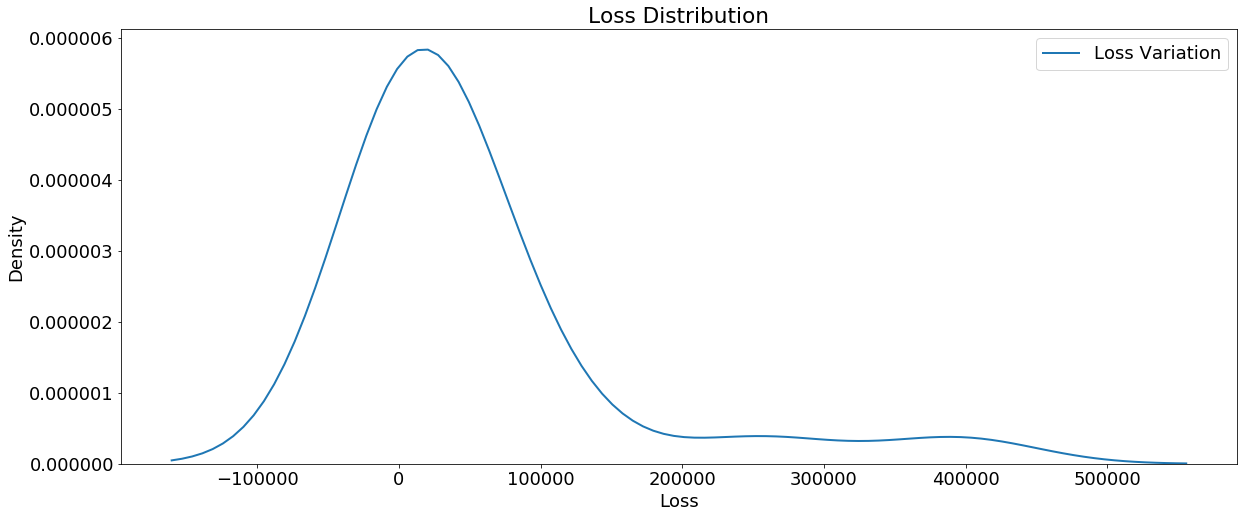

In [13]:
os.chdir('./bt_plots')
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions 
sns.kdeplot(bayes_params['loss'], label = 'Loss Variation', linewidth = 2)
plt.legend()
plt.xlabel('Loss'); plt.ylabel('Density'); plt.title('Loss Distribution');
plt.savefig(file_suffix+'_loss.png')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


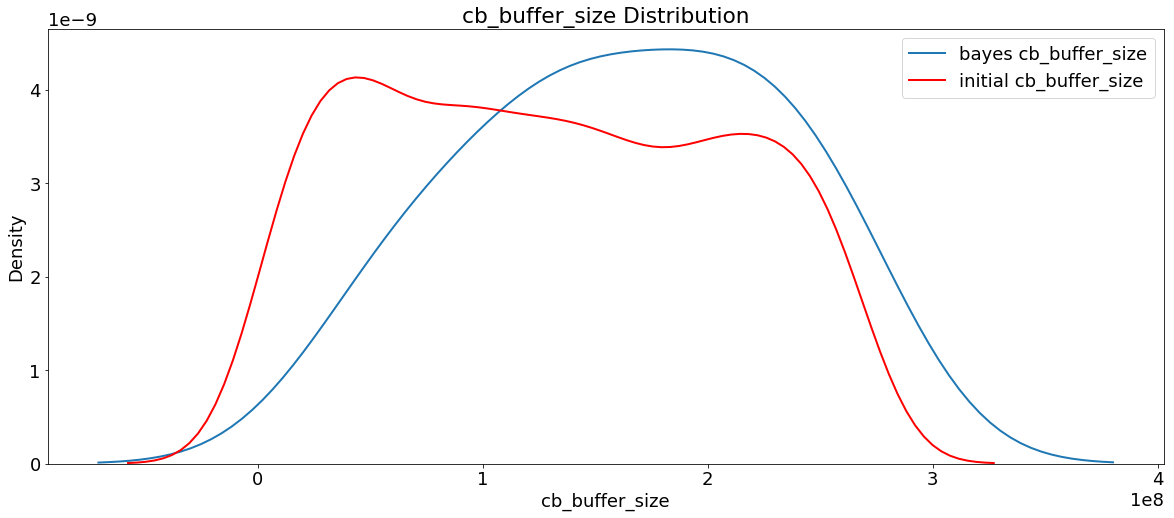

In [14]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18


sns.kdeplot(bayes_params['cb_buffer_size'], label = 'bayes cb_buffer_size', linewidth = 2)
sns.kdeplot(cb_buffer_size_dist,color="red",linewidth=2, label = 'initial cb_buffer_size')

plt.legend()
plt.xlabel('cb_buffer_size'); plt.ylabel('Density'); plt.title('cb_buffer_size Distribution');
plt.savefig(file_suffix+'_cb_buffer_size.png')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


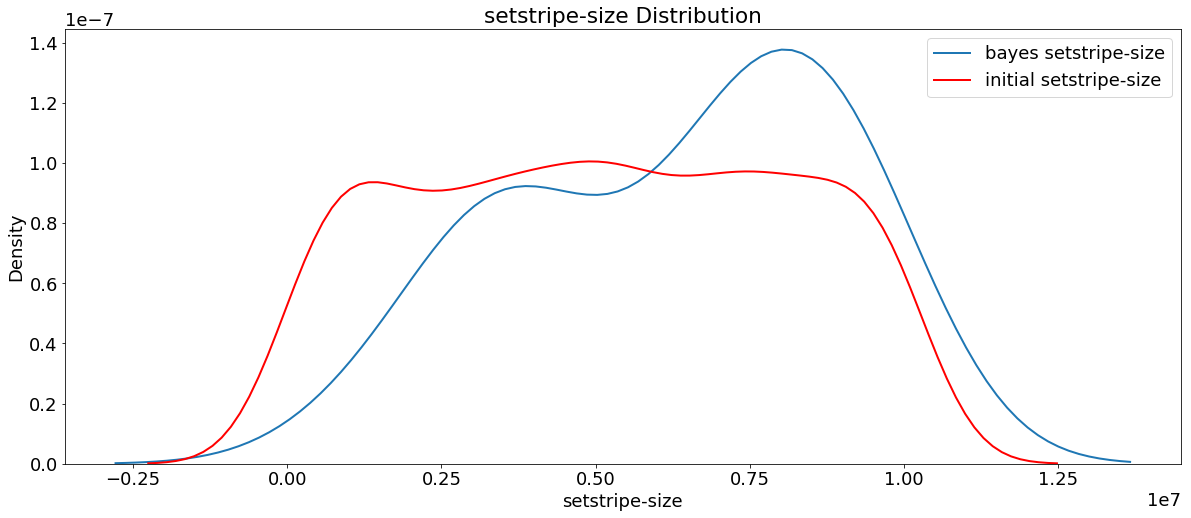

In [15]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

sns.kdeplot(bayes_params['setstripe-size'], label = 'bayes setstripe-size', linewidth = 2)
sns.kdeplot(setstripe_size_dist,color="red",linewidth=2, label = 'initial setstripe-size')

plt.legend()
plt.xlabel('setstripe-size'); plt.ylabel('Density'); plt.title('setstripe-size Distribution');
plt.savefig(file_suffix+'_setstripe-size.png')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


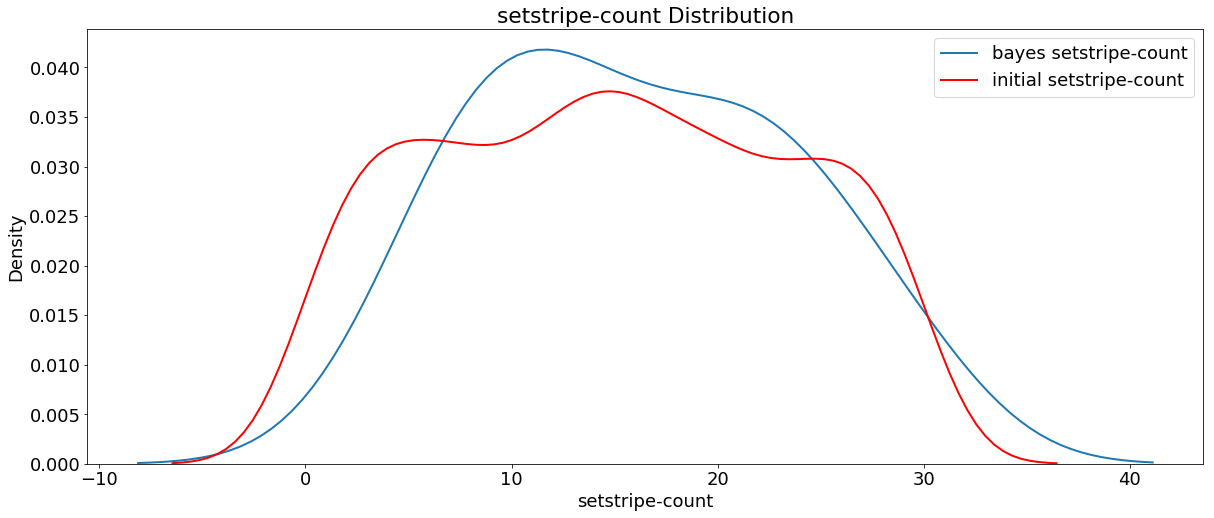

In [16]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

sns.kdeplot(bayes_params['setstripe-count'], label = 'bayes setstripe-count', linewidth = 2)
sns.kdeplot(setstripe_count_dist,color="red",linewidth=2, label = 'initial setstripe-count')

plt.legend()
plt.xlabel('setstripe-count'); plt.ylabel('Density'); plt.title('setstripe-count Distribution');
plt.savefig(file_suffix+'_setstripe-count.png')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


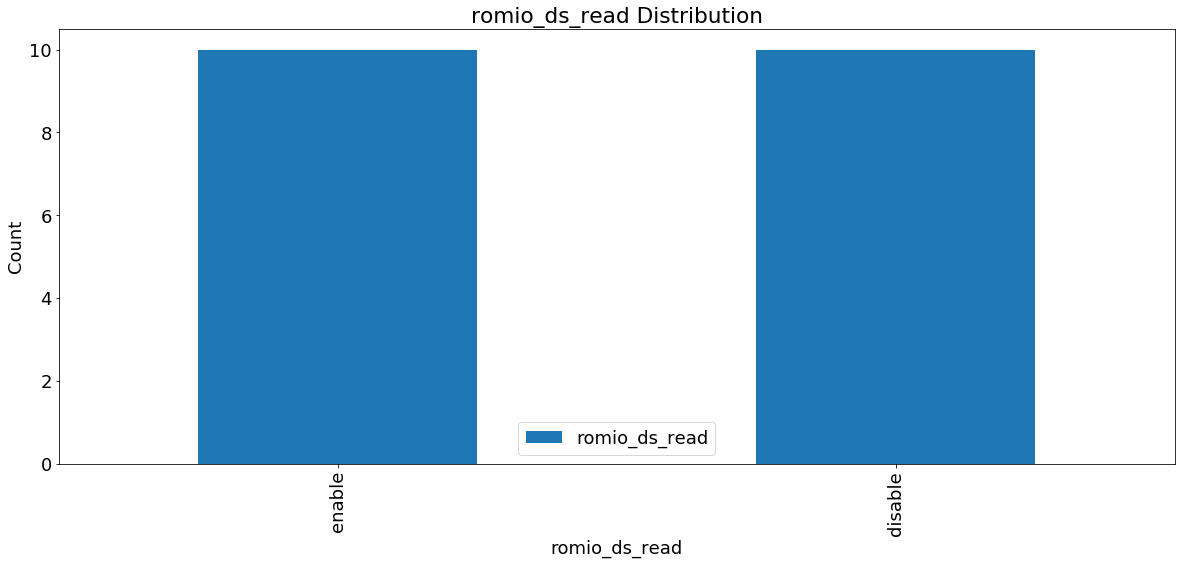

In [17]:
plt.figure(figsize = (20, 8))
from scipy.stats import itemfreq
plt.rcParams['font.size'] = 18
bayes_params['romio_ds_read'].value_counts().plot.bar()#plt.hist(romio_ds_read_dist,color="red",linewidth=2, label = 'initial romio_ds_read')

plt.legend()
plt.xlabel('romio_ds_read'); plt.ylabel('Count'); plt.title('romio_ds_read Distribution');
plt.savefig(file_suffix+'_romio_ds_read.png')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


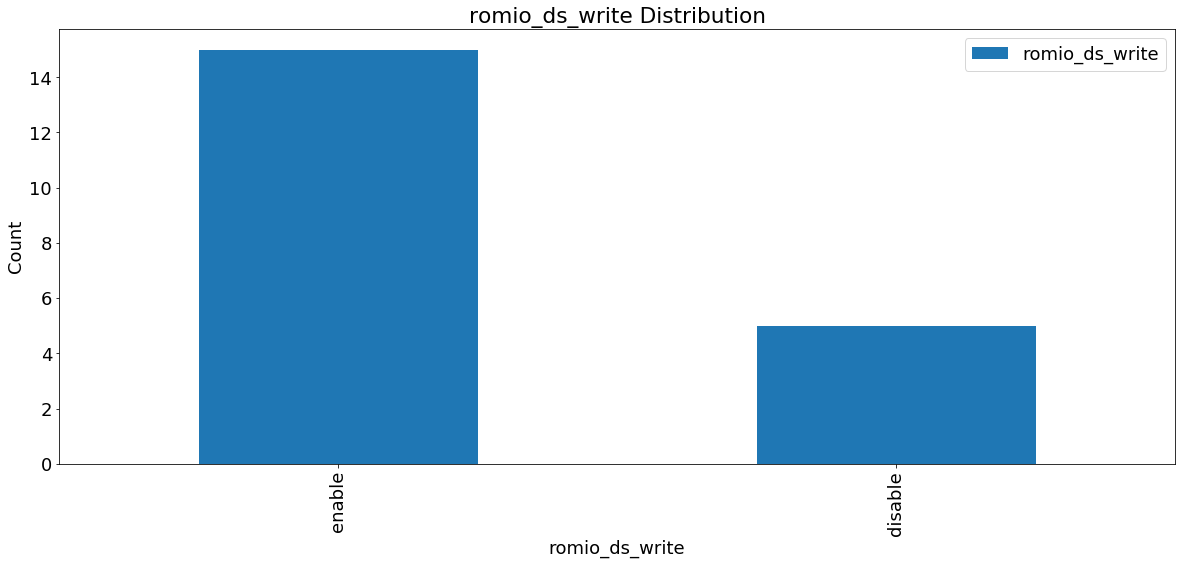

In [18]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

#plt.hist(bayes_params['romio_ds_write'], label = 'bayes romio_ds_write', linewidth = 2)
#plt.hist(romio_ds_write_dist,color="red",linewidth=2, label = 'initial romio_ds_write')
bayes_params['romio_ds_write'].value_counts().plot.bar()
plt.legend()
plt.xlabel('romio_ds_write'); plt.ylabel('Count'); plt.title('romio_ds_write Distribution');
plt.savefig(file_suffix+'_romio_ds_write.png')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


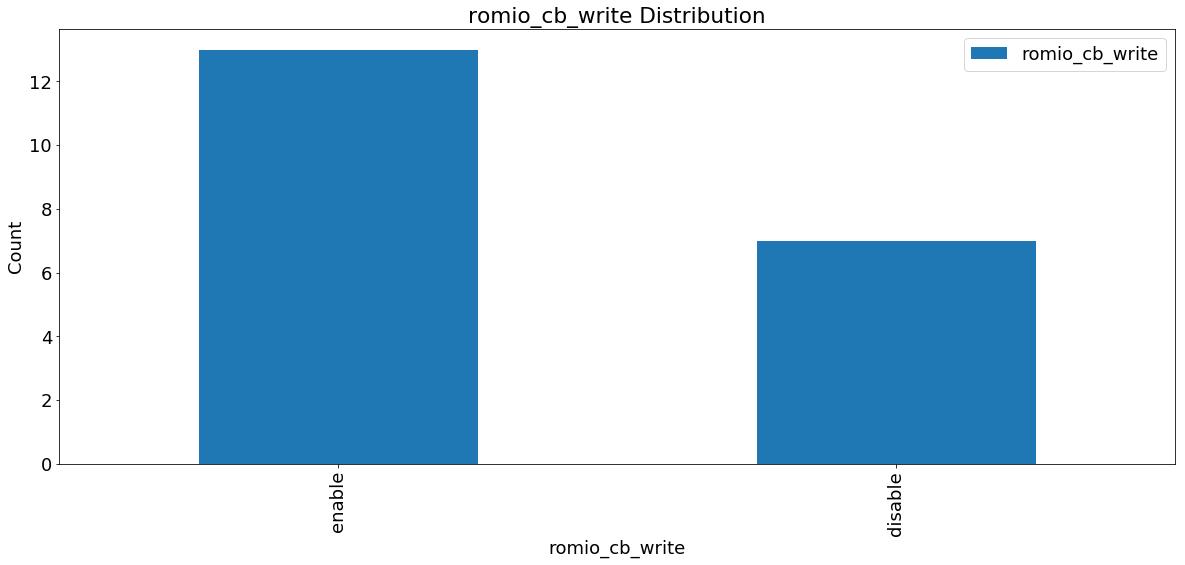

In [19]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

bayes_params['romio_cb_write'].value_counts().plot.bar()#plt.hist(romio_ds_write_dist,color="red",linewidth=2, label = 'initial romio_cb_write')

plt.legend()
plt.xlabel('romio_cb_write'); plt.ylabel('Count'); plt.title('romio_cb_write Distribution');
plt.savefig(file_suffix+'_romio_cb_write.png')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


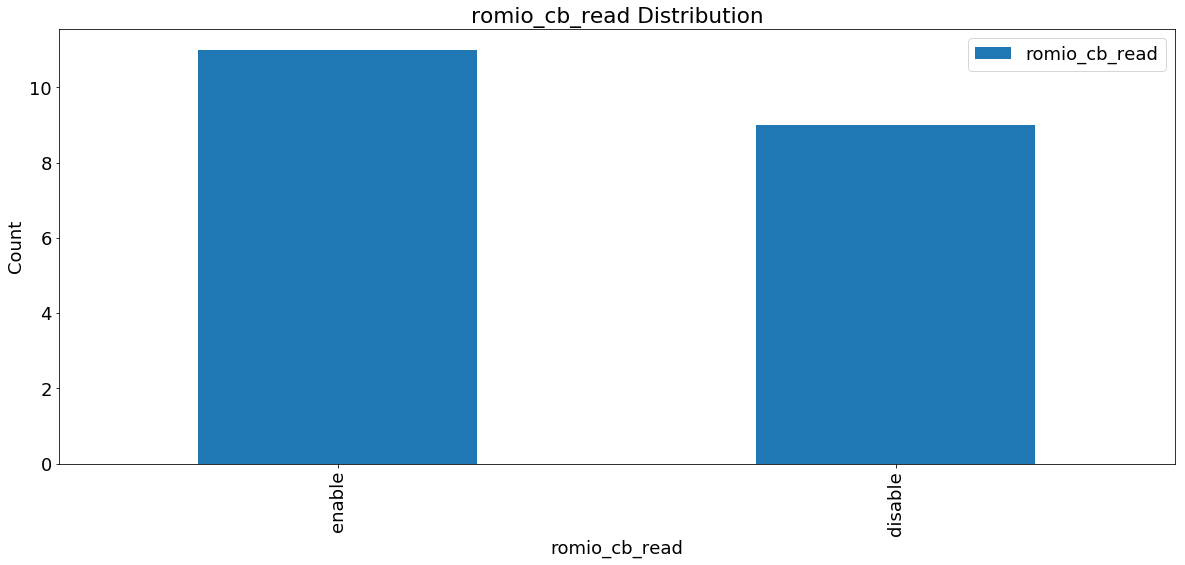

In [20]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

bayes_params['romio_cb_read'].value_counts().plot.bar()#plt.hist(romio_cb_read_dist,color="red",linewidth=2, label = 'initial romio_cb_read')

plt.legend()
plt.xlabel('romio_cb_read'); plt.ylabel('Count'); plt.title('romio_cb_read Distribution');
plt.savefig(file_suffix+'_romio_cb_read.png')

In [21]:
os.chdir('../')